# Machine Learning: Homework 2

a)

Dimensional reduction is classified as unsupervised learning because we want to find the important features of the data in a lower dimension. Unlike supervised learning, these important features in the data are not labeled, and reducing to a lower dimension can help us visualize the data and identify the features, and thus we can classify the data according to the features.

The data in Homework 1 has labels, while the data for tSNE does not have labels.


b)  Arguments in the function tsne

X is the dataset, no_dims is the reduced dimensionality, initial_dims is the dimensionality after PCA, perplexity is defined as 2 to the power of the Shannon entropy and may be viewed as a knob that sets the number of effective nearest neighbors.


In [3]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = max(sum(P),1e-13)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y




c)

In [2]:
#Download data (stored on Mohamed's github account)
!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/PCA_tutorial_data/Tutorial_Data.zip
!unzip -j Tutorial_Data.zip

--2024-06-07 23:01:47--  https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/PCA_tutorial_data/Tutorial_Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4729128 (4.5M) [application/zip]
Saving to: ‘Tutorial_Data.zip’

Tutorial_Data.zip   100%[===================>]   4.51M  17.0MB/s    in 0.3s    

2024-06-07 23:01:48 (17.0 MB/s) - ‘Tutorial_Data.zip’ saved [4729128/4729128]

Archive:  Tutorial_Data.zip
  inflating: labels_gaugeTheory_L80.txt  
  inflating: ._labels_gaugeTheory_L80.txt  
  inflating: labels_gaugeTheory_L40.txt  
  inflating: ._labels_gaugeTheory_L40.txt  
  inflating: spinConfigs_Ising_L20.txt  
  inflating: ._spinConfigs_Ising_L20.txt  
  inflating: labels_gaugeTheory_L20.txt  
  inflating: ._labels_gau

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# reads in the spin configurations for the Ising model
spinConfigs_Ising_L20 = np.loadtxt("spinConfigs_Ising_L20.txt")
spinConfigs_Ising_L40 = np.loadtxt("spinConfigs_Ising_L40.txt")
spinConfigs_Ising_L80 = np.loadtxt("spinConfigs_Ising_L80.txt")

temperatures_Ising_L20 = np.loadtxt("temperatures_Ising_L20.txt")
temperatures_Ising_L40 = np.loadtxt("temperatures_Ising_L40.txt")
temperatures_Ising_L80 = np.loadtxt("temperatures_Ising_L80.txt")

In [8]:

if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on two-dimensional classical Ising model...")
    X_20 = np.loadtxt("spinConfigs_Ising_L20.txt")
    Y_20 = tsne(X_20, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on two-dimensional classical Ising model...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.748357
Iteration 10: error is 20.064362
Iteration 20: error is 17.654841
Iteration 30: error is 17.040830
Iteration 40: error is 17.027873
Iteration 50: error is 17.036538
Iteration 60: error is 17.022894
Iteration 70: error is 17.015894
Iteration 80: error is 17.015127
Iteration 90: error is 17.015333
Iteration 100: error is 17.015858
Iteration 110: error is 2.734847
Iteration 120: error is 2.527695
Iteration 130: error is 2.205936
Iteration 140: error is 2.064468
Iteration 150: error is 1.976877
Iteration 160: error is 1.914330
Iteration 170: error is 1.866005
Iteration 180: error is 1.82

In [9]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on two-dimensional classical Ising model...")
    X_40 = np.loadtxt("spinConfigs_Ising_L40.txt")
    Y_40 = tsne(X_40, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on two-dimensional classical Ising model...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 2.897560
Iteration 10: error is 21.010331
Iteration 20: error is 18.150124
Iteration 30: error is 17.384206
Iteration 40: error is 17.238708
Iteration 50: error is 17.227938
Iteration 60: error is 17.211437
Iteration 70: error is 17.206559
Iteration 80: error is 17.197747
Iteration 90: error is 17.192735
Iteration 100: error is 17.183117
Iteration 110: error is 2.669013
Iteration 120: error is 2.443493
Iteration 130: error is 2.311112
Iteration 140: error is 2.220193
Iteration 150: error is 2.149572
Iteration 160: error is 2.091634
Iteration 170: error is 2.044584
Iteration 180: error is 2.00

In [10]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on two-dimensional classical Ising model...")
    X_80 = np.loadtxt("spinConfigs_Ising_L80.txt")
    Y_80 = tsne(X_80, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on two-dimensional classical Ising model...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.548898
Iteration 10: error is 20.720599
Iteration 20: error is 17.985075
Iteration 30: error is 17.036721
Iteration 40: error is 16.814388
Iteration 50: error is 16.643795
Iteration 60: error is 16.386463
Iteration 70: error is 16.382212
Iteration 80: error is 16.375758
Iteration 90: error is 16.333292
Iteration 100: error is 16.315288
Iteration 110: error is 2.429656
Iteration 120: error is 2.229321
Iteration 130: error is 2.163584
Iteration 140: error is 2.120583
Iteration 150: error is 2.083544
Iteration 160: error is 2.049918
Iteration 170: error is 2.020414
Iteration 180: error is 1.99

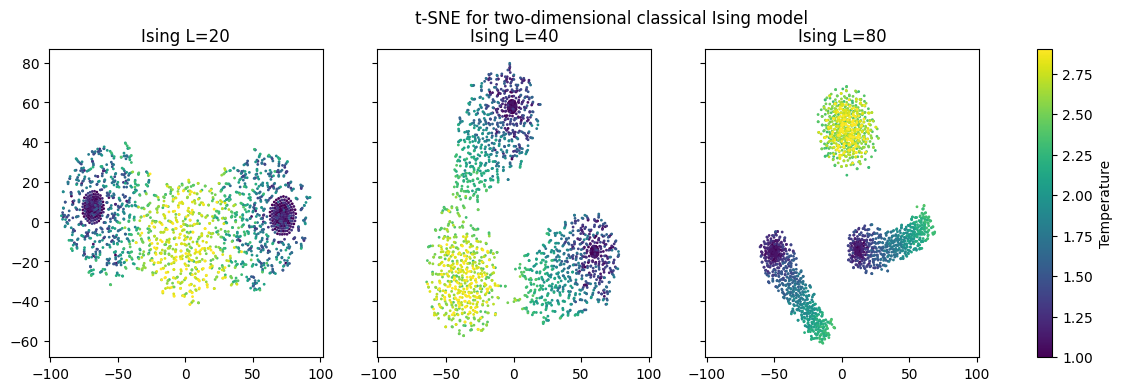

In [34]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex = True, sharey = True)

# L=20
sc1=axes[0].scatter(Y_20[:, 0], Y_20[:, 1], 1, c=temperatures_Ising_L20)
axes[0].set_title('Ising L=20')

# L=40
sc2=axes[1].scatter(Y_40[:, 0], Y_40[:, 1], 1, c=temperatures_Ising_L40)
axes[1].set_title('Ising L=40')

# L=80
sc3=axes[2].scatter(Y_80[:, 0], Y_80[:, 1], 1, c=temperatures_Ising_L80)
axes[2].set_title('Ising L=80')

# Add a main title for the entire figure
fig.suptitle('t-SNE for two-dimensional classical Ising model')

cbar = fig.colorbar(sc3, ax=axes, orientation='vertical')
cbar.set_label('Temperature')



d) Explain results from part c)
* How do the clustering results from t-SNE change as L increases?

As L increases, the distance between each cluster is larger.

* Compare your results for the Ising model with Figure 6 of Reference [3]. In this figure, t-SNE
was applied to the two-dimensional Ising model on a lattice with L = 30. Do you observe
similar behaviour?

We observed similar behavior. For all of the L values, the data are divided into three clusters, two of which are cool regions and the remaining one is a hot region.

* Compare your results with the results of Tutorial 5, which studied the same problem of
phase identification for Ising spin configurations, but used PCA rather than t-SNE. Discuss
any differences that you observe.

The shapes of the clusters are different. t-SNE preserves local structure while PCA does not.





* Show that if you apply the t-SNE code twice to the same dataset, you get different results. Why do such differences occur?

In [43]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on two-dimensional classical Ising model...")
    X_20 = np.loadtxt("spinConfigs_Ising_L20.txt")
    Y_20 = tsne(X_20, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on two-dimensional classical Ising model...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.748357
Iteration 10: error is 20.547893
Iteration 20: error is 17.855700
Iteration 30: error is 16.987208
Iteration 40: error is 16.993165
Iteration 50: error is 17.030327
Iteration 60: error is 17.025912
Iteration 70: error is 17.020193
Iteration 80: error is 17.018074
Iteration 90: error is 17.016954
Iteration 100: error is 17.016574
Iteration 110: error is 2.727318
Iteration 120: error is 2.436512
Iteration 130: error is 2.187541
Iteration 140: error is 2.062644
Iteration 150: error is 1.980281
Iteration 160: error is 1.917608
Iteration 170: error is 1.869253
Iteration 180: error is 1.82

Text(0.5, 1.0, 'Ising L=20, Run 2')

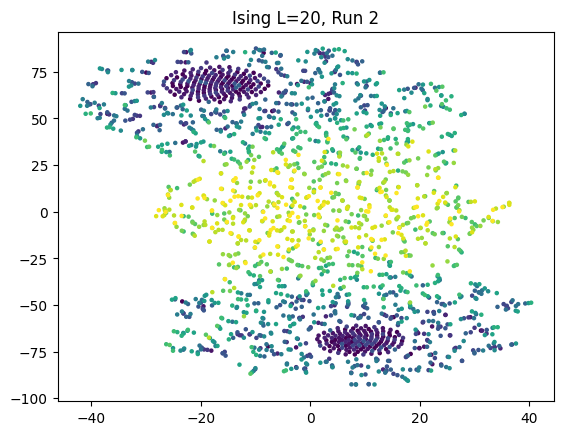

In [45]:
plt.scatter(Y_20[:, 0], Y_20[:, 1], 5, c=temperatures_Ising_L20)
plt.title('Ising L=20, Run 2')

We run the L=20 dataset twice and find that the result is different from that of the first run. The clusters have a different orientation, while there are the same number of clusters. This is because in the tsne function, there is a random initialization: Y = np.random.randn(n, no_dims).

e)

In [35]:
# reads in the spin configurations for the Ising gauge theory
spinConfigs_gaugeTheory_L20 = np.loadtxt("spinConfigs_gaugeTheory_L20.txt")
spinConfigs_gaugeTheory_L40 = np.loadtxt("spinConfigs_gaugeTheory_L40.txt")
spinConfigs_gaugeTheory_L80 = np.loadtxt("spinConfigs_gaugeTheory_L80.txt")

labels_gaugeTheory_L20 = np.loadtxt("labels_gaugeTheory_L20.txt")
labels_gaugeTheory_L40 = np.loadtxt("labels_gaugeTheory_L40.txt")
labels_gaugeTheory_L80 = np.loadtxt("labels_gaugeTheory_L80.txt")

In [36]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on classical Ising gauge theory...")
    X_20_gauge = np.loadtxt("spinConfigs_gaugeTheory_L20.txt")
    Y_20_gauge = tsne(X_20_gauge, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on classical Ising gauge theory...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 3.422550
Iteration 10: error is 21.044469
Iteration 20: error is 20.339433
Iteration 30: error is 21.169914
Iteration 40: error is 21.133795
Iteration 50: error is 21.182093
Iteration 60: error is 21.807675
Iteration 70: error is 21.739244
Iteration 80: error is 21.894632
Iteration 90: error is 21.817209
Iteration 100: error is 21.794007
Iteration 110: error is 3.921020
Iteration 120: error is 3.519477
Iteration 130: error is 3.337545
Iteration 140: error is 3.221682
Iteration 150: error is 3.119074
Iteration 160: error is 3.040426
Iteration 170: error is 2.963940
Iteration 180: error is 2.856842
Iteration 190: error is 2.793196
Iteration 200: error is 2.767074
Iteration 210: error is 2.75

In [38]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on classical Ising gauge theory...")
    X_40_gauge = np.loadtxt("spinConfigs_gaugeTheory_L40.txt")
    Y_40_gauge = tsne(X_40_gauge, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on classical Ising gauge theory...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 5.169702
Iteration 10: error is 20.820016
Iteration 20: error is 20.490403
Iteration 30: error is 20.961885
Iteration 40: error is 20.710170
Iteration 50: error is 20.715591
Iteration 60: error is 21.013407
Iteration 70: error is 21.138499
Iteration 80: error is 21.204208
Iteration 90: error is 20.761723
Iteration 100: error is 20.961244
Iteration 110: error is 3.631801
Iteration 120: error is 3.198269
Iteration 130: error is 3.022091
Iteration 140: error is 2.932410
Iteration 150: error is 2.871976
Iteration 160: error is 2.824376
Iteration 170: error is 2.787419
Iteration 180: error is 2.755877
Iteration 190: error is 2.728192
Iteration 200: error is 2.703948
Iteration 210: error is 2.68

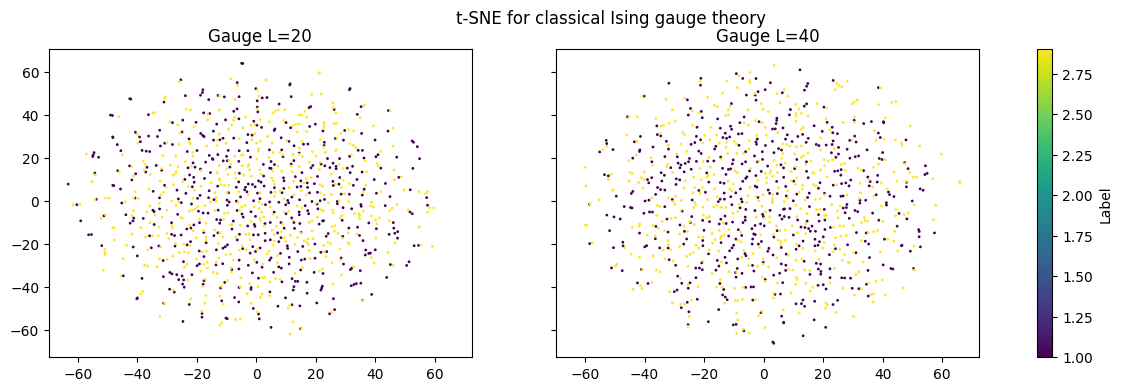

In [42]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharex = True, sharey = True)

# L=20
sc1_gauge=axes[0].scatter(Y_20_gauge[:, 0], Y_20_gauge[:, 1], 1, c=labels_gaugeTheory_L20)
axes[0].set_title('Gauge L=20')

# L=40
sc2_gauge=axes[1].scatter(Y_40_gauge[:, 0], Y_40_gauge[:, 1], 1, c=labels_gaugeTheory_L40)
axes[1].set_title('Gauge L=40')


# Add a main title for the entire figure
fig.suptitle('t-SNE for classical Ising gauge theory')

cbar = fig.colorbar(sc2, ax=axes, orientation='vertical')
cbar.set_label('Label')


We find that t-SNE fails and is unable to produce distinct clusters when applied
to gauge theory data.

f) Explain why t-SNE fails to produce distinct clusters when applied to classical Ising gauge theory
data.

We can find two different topologically-ordered
configurations that are not “close” in terms of their Euclidean distance. If we have such two configurations and they belong to the same phase, they can be separated widely apart and thus not classified into the same cluster. Therefore, the data points are spreaded all over the 2-dimensional space and t-SNE does not converge.